In [26]:
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logsumexp
sys.path.append('vbpi-torch/rooted')

import torch
from dataManipulation import *
from treeManipulation import *
from utils import tree_summary, summary, summary_raw, get_support_info
from vbpi import VBPI

In [27]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp,erf
from autograd.scipy.stats import norm
from autograd import grad

import pandas as pd

#from autograd_gamma import gamma, gammainc, gammaincc, gammaincln, gammainccln

import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

from tree import Tree
from optimizer import Optimizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [83]:
data_set = "DS1"
pop_size = 5.0 # exponential parameter for constant pop size prior
data_file = '../dat/'+data_set+'/'+data_set+'.pickle'

# models
models = ["reparam","reinforce","BEAST","VBPI"]

# my files
reparam_file = '../results/'+data_set+'/'+data_set+'_2024_12_04_22_03_11_reparam.pickle'
reinforce_file = '../results/'+data_set+'/'+data_set+'_2024_12_04_22_03_11_reinforce.pickle'

# Beast file
BEAST_file = '../dat/'+data_set+'/'+data_set+'_fixed_pop_golden_run.log'
BEAST_MLL_file = '../dat/'+data_set+'/'+data_set+'_MLL.txt'
BEAST_burnin = 250000

# VPBI files
VBPI_path = '../results/'+data_set+'/'
VBPI_path = VBPI_path + "mcmc_vimco_10_psp_fixed_pop_fixed_rate_2024-12-05_02-58-17"

# Requirements for VBPI

In [84]:
# load the sequence data and estimate the subsplit support
data, taxa = loadData('../dat/'+data_set+'/'+data_set+'.nexus', 'nexus')
mcmc_support_trees_dict, mcmc_support_trees_wts = summary('../dat/'+data_set+'/'+data_set+'_fixed_pop_support_short_run', 'nexus', burnin=250)
rootsplit_supp_dict, subsplit_supp_dict = get_support_info(taxa, mcmc_support_trees_dict)
#del mcmc_support_trees_dict, mcmc_support_trees_wts

In [85]:
# load the ground truth
#mcmc_sampled_trees_dict, mcmc_sampled_trees_wts, _ = tree_summary('../dat/DS1/DS1_fixed_pop_golden_run.trees', 'nexus', burnin=25001)
emp_tree_freq = None#{mcmc_sampled_trees_dict[tree_id]: tree_wts for tree_id, tree_wts in sorted(mcmc_sampled_trees_wts.items(), key=lambda x:x[1], reverse=True)}
sample_info = [0.0 for taxon in taxa]
#del mcmc_sampled_trees_dict, mcmc_sampled_trees_wts

In [86]:
# set up the model
VBPI_model = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
             emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
             sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
             log_pop_size_offset=math.log(5.0))

# Load in the relevant files

In [87]:
# VBPI
VBPI_model.load_from(VBPI_path+'.pt')
VBPI_ELBO_ests = np.load(VBPI_path+'_test_lb.npy')
VBPI_run_times = np.load(VBPI_path+'_run_time.npy')
VBPI_iters = np.load(VBPI_path+'_iters.npy')

# BEAST
BEAST_data = pd.read_csv(BEAST_file, sep = '\t',skiprows=[0,1,2])

# my models
with open(reinforce_file, 'rb') as f:
    optim_reinforce = pickle.load(f)
    
with open(reparam_file, 'rb') as f:
    optim_reparam = pickle.load(f)

# draw the random tree using a newick file

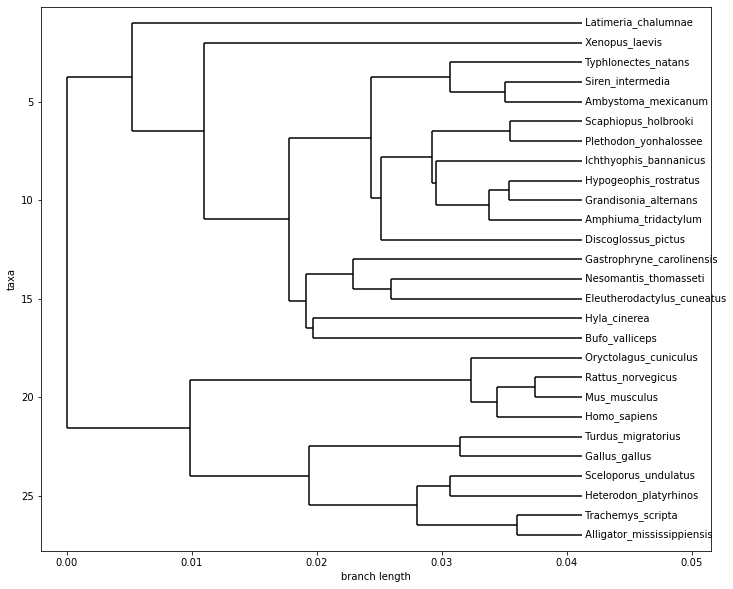

-6984.796818455874
-42.590143723148394
-7027.386962179023


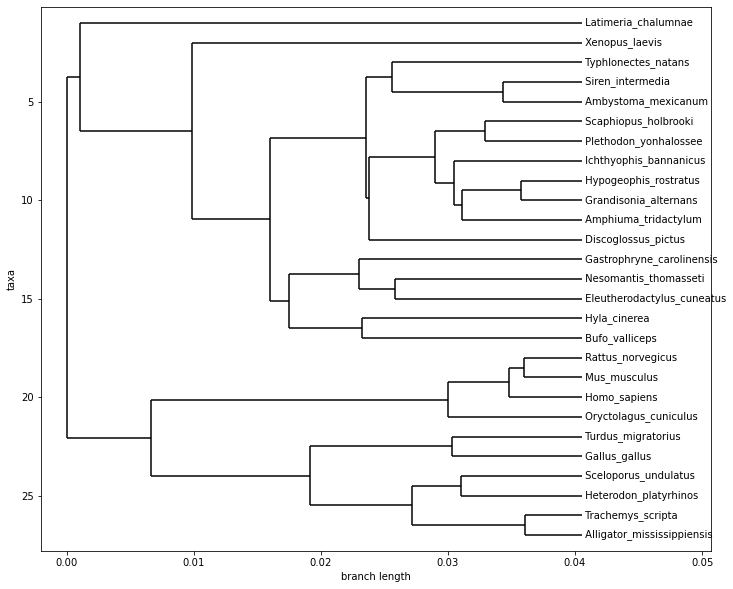

-6985.505348989498
-42.60525069178157
-7028.110599681279


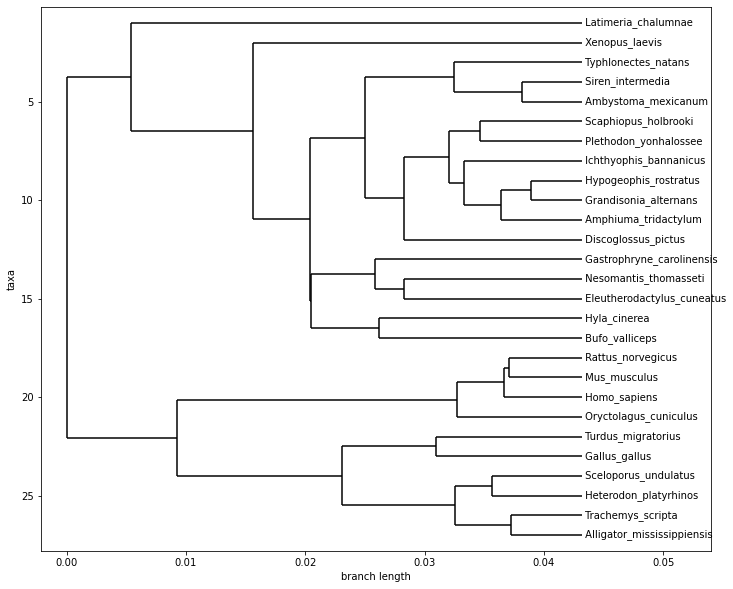

-6988.035163961862
-42.57578518703464
-7030.610949148897


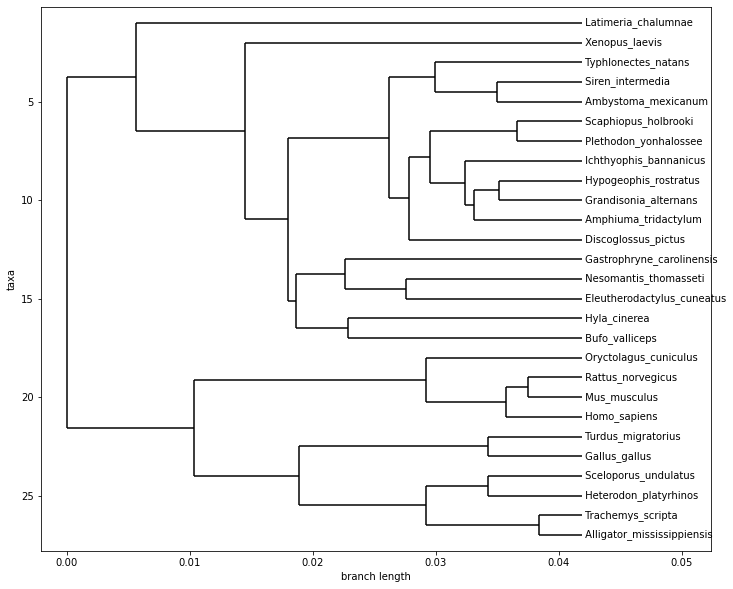

-6980.497793861616
-42.573928978566634
-7023.071722840183


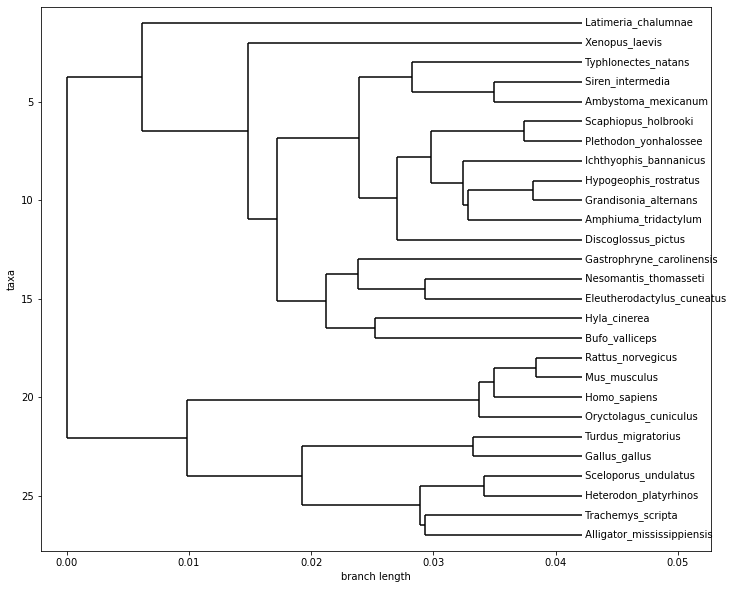

-6988.0121120142085
-42.59605758904736
-7030.608169603256


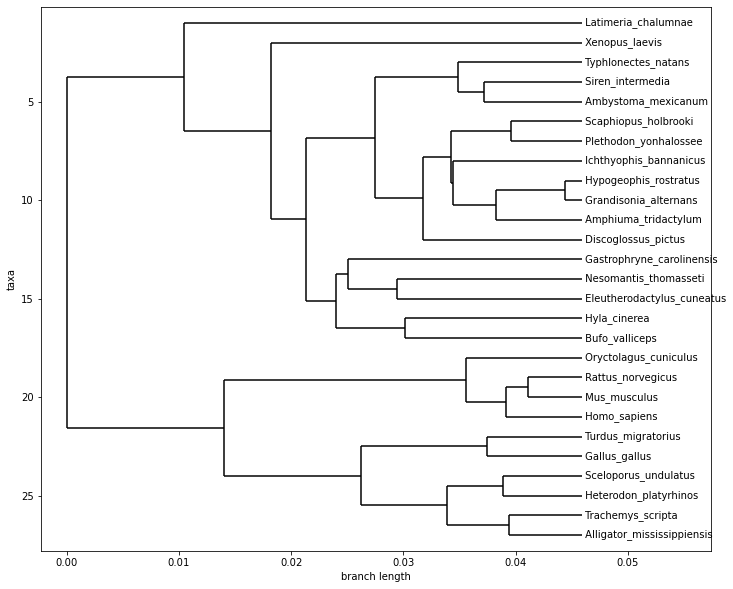

-6981.69681518538
-42.56982263760048
-7024.266637822981


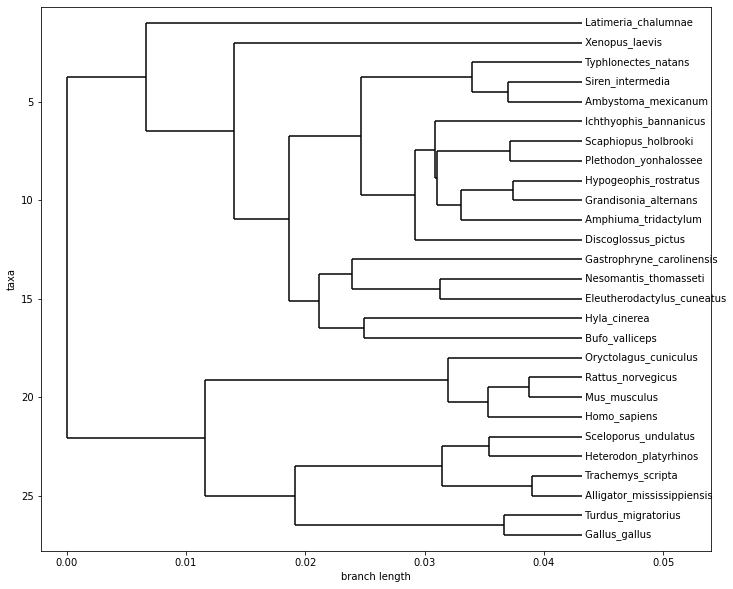

-6981.47188027069
-42.57397641616009
-7024.04585668685


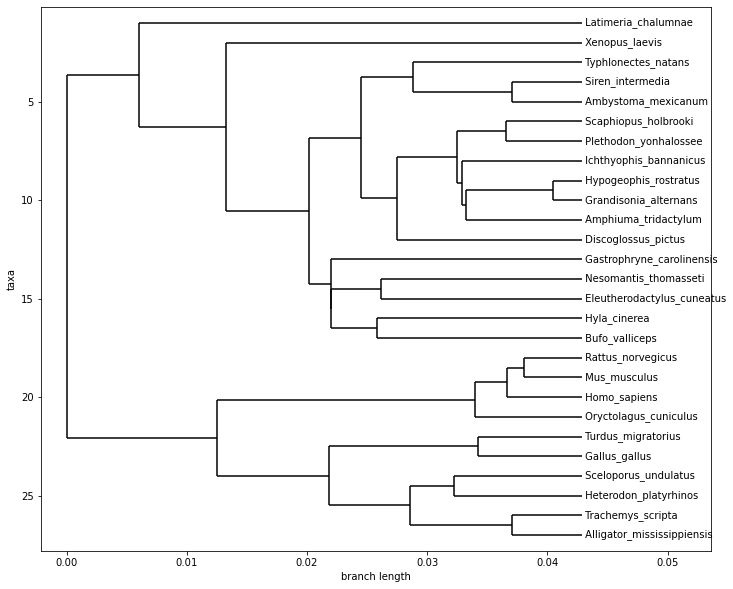

-6988.249684083215
-42.58462914412632
-7030.834313227341


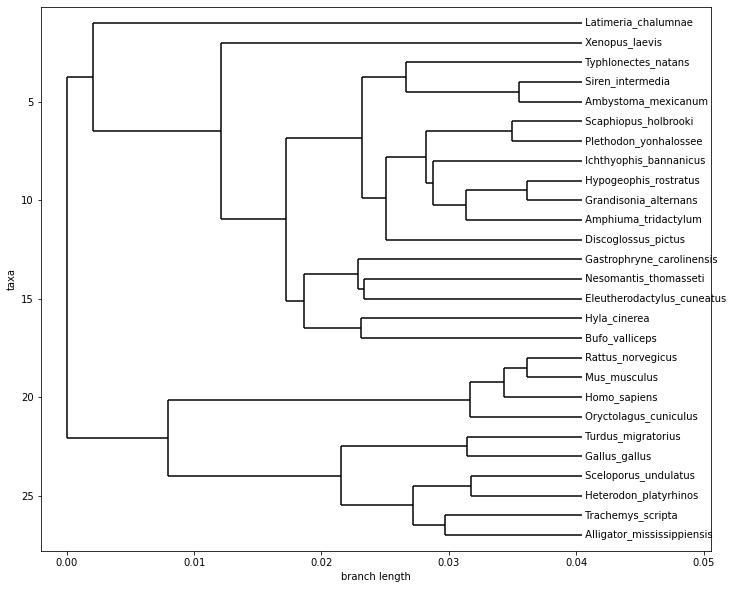

-6983.5294987249235
-42.59657710929752
-7026.126075834221


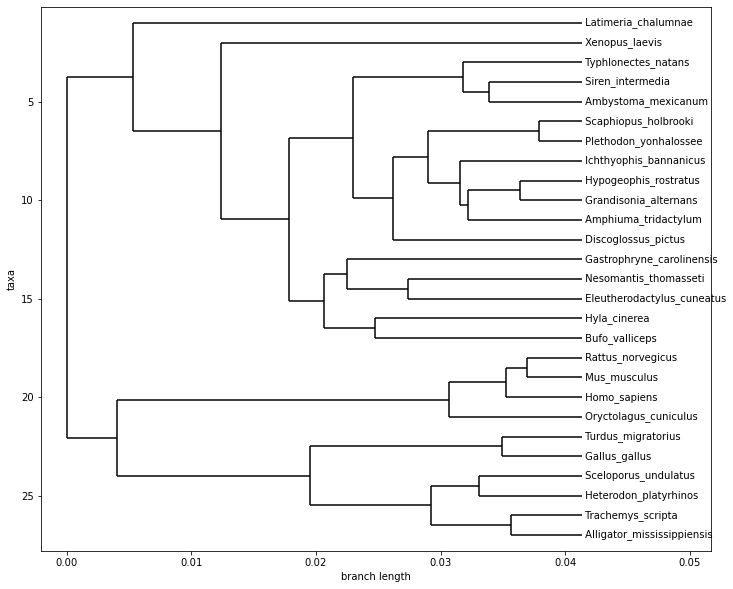

-6975.934166560637
-42.553746848343074
-7018.487913408981


In [88]:
theta = optim_reparam.theta

with open(data_file, 'rb') as f:
    DS = pickle.load(f)

genomes = []
species = []
for key in DS:
    genomes.append(DS[key])
    species.append(key)
    
n_species = len(species)

# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = np.array([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = float)
tree_log_probs = np.log(tree_log_probs)

for _ in range(10):
    Z = np.random.normal(np.ones_like(theta[0]))
    log_times = np.exp(theta[1])*Z+theta[0]
    log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)

    def write_newick(node):

        if node.children == []:
            return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time)
        elif node.parent is None:
            return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
        else:
            bl = node.parent.coal_time - node.coal_time
            return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)

    print(tree.log_like)
    print(tree.log_prior)
    print(tree.log_p)

# plot estimated ELBO over time

In [89]:
ymax = max(list(optim_reparam.ELBO_ests) + list(optim_reinforce.ELBO_ests) + list(VBPI_ELBO_ests)) + 1
ymax

-7158.492613830583

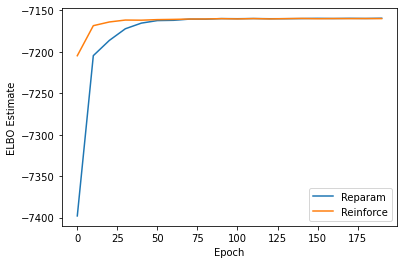

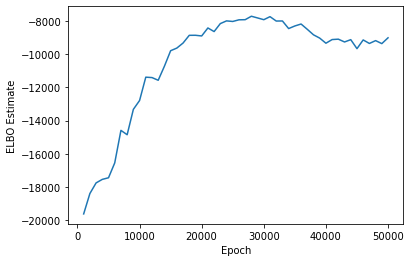

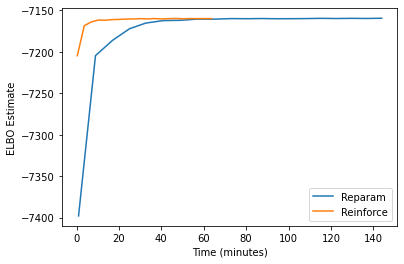

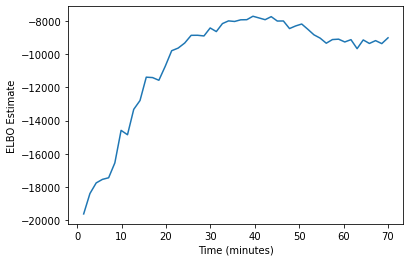

In [107]:
plt.plot(optim_reparam.epochs,optim_reparam.ELBO_ests)
plt.plot(optim_reinforce.epochs,optim_reinforce.ELBO_ests)
plt.legend(["Reparam","Reinforce","VBPI"])
plt.xlabel("Epoch")
plt.ylabel("ELBO Estimate")
#plt.ylim([ymax-1000,ymax])
plt.show()

plt.plot(VBPI_iters,VBPI_ELBO_ests)
plt.xlabel("Epoch")
plt.ylabel("ELBO Estimate")
#plt.ylim([ymax-1000,ymax])
plt.show()

plt.plot(np.cumsum(optim_reparam.run_times)/60,
         optim_reparam.ELBO_ests)
plt.plot(np.cumsum(optim_reinforce.run_times)/60,
         optim_reinforce.ELBO_ests)
plt.legend(["Reparam","Reinforce","VBPI"])
plt.xlabel("Time (minutes)")
plt.ylabel("ELBO Estimate")
#plt.ylim([ymax-1000,ymax])
plt.show()

plt.plot(np.cumsum(VBPI_run_times)/60,
         VBPI_ELBO_ests)
plt.xlabel("Time (minutes)")
plt.ylabel("ELBO Estimate")
#plt.ylim([ymax-1000,ymax])
plt.show()

In [91]:
tree_lengths = {}
root_heights = {}
log_likes = {}
log_priors = {}
log_qs = {}
MLLs = {}

# Get data from BEAST

In [94]:
# get lengths from BEAST
tree_lengths["BEAST"] = BEAST_data.treeLength[BEAST_data.state > BEAST_burnin].to_numpy()
root_heights["BEAST"] = BEAST_data['treeModel.rootHeight'][BEAST_data.state > BEAST_burnin].to_numpy()
log_likes["BEAST"] = BEAST_data.likelihood[BEAST_data.state > BEAST_burnin].to_numpy()
log_priors["BEAST"] = BEAST_data.prior[BEAST_data.state > BEAST_burnin].to_numpy()

# extract MLL from beast log
with open(BEAST_MLL_file, "r") as text_file:
    line = text_file.readlines()[-4]
ind = np.where([not x in "-1234567890." for x in line])[0][-2]
MLLs["BEAST"] = float(line[(ind+1):-1])

# Get data from VBPI

In [106]:
self = VBPI_model
n_runs = 10
n_particles = 1000

root_heights["VBPI"] = []
tree_lengths["VBPI"] = []
log_priors["VBPI"] = []
log_likes["VBPI"] = []
MLLs["VBPI"] = []

for i in range(n_runs):
    print(i)
    with torch.no_grad():
        samp_trees = [self.tree_model.sample_tree() for particle in range(n_particles)]
        [namenum(tree, self.taxa) for tree in samp_trees]
        logq_tree = torch.stack([self.logq_tree(tree) for tree in samp_trees])

        samp_branch, logq_height, height, event_info = self.branch_model(samp_trees)
        log_clock_rate, logq_clock_rate = self.clock_model.sample(n_particles=n_particles)
        samp_branch = samp_branch * log_clock_rate.exp()
        logll = torch.stack([self.phylo_model.loglikelihood(branch, tree) for branch, tree in zip(*[samp_branch, samp_trees])])

        self.tree_prior_model.update_batch(height, event_info)
        coalescent_param, logq_prior = self.tree_prior_model.sample_pop_size(n_particles=n_particles)
        logp_coalescent_prior, _ = self.tree_prior_model(coalescent_param, False)

        logp_clock_rate = self.clock_model(log_clock_rate)

        # get values
        root_heights["VBPI"].extend(list(height[:,0].numpy()))
        tree_lengths["VBPI"].extend(list(np.sum(samp_branch.numpy(),axis=1)))
        log_priors["VBPI"].extend(list(logp_coalescent_prior.numpy() + logp_clock_rate))
        log_likes["VBPI"].extend(list(logll.numpy()))
        MLLs["VBPI"].append(torch.logsumexp(logll + logp_coalescent_prior + logp_clock_rate - logq_tree - logq_height - logq_prior - logq_clock_rate - math.log(n_particles), 0).item())

0
1
2
3
4
5
6
7
8
9


# Get data from my code

In [96]:
def get_tree_length(tree):
    tree_length = 0
    for leaf in tree.leaves:
        tree_length += leaf.parent.coal_time - leaf.coal_time

    for node in tree.nodes[:-1]:
        tree_length += node.parent.coal_time - node.coal_time
        
    return tree_length

In [97]:
n_exp = 10
n_particles = 1000

for model in ["reparam","reinforce"]:

    if model == "reparam":
        theta = optim_reparam.theta
    elif model == "reinforce":
        theta = optim_reinforce.theta
    
    root_heights[model] = []
    tree_lengths[model] = []
    log_priors[model] = []
    log_likes[model] = []
    MLLs[model] = []

    for i in range(n_exp):
        
        print(i)
        Zs = np.random.normal(size=(n_particles,n_species,n_species))
        p_minus_qs = []

        for j,Z in enumerate(Zs):
            log_times = np.exp(theta[1])*Z+theta[0]
            log_times = log_times + np.triu(np.full(n_species, np.inf))
            tree = Tree(optim_reparam.theta,log_times,deepcopy(tree_log_probs),
                        pop_size=pop_size)

            p_minus_qs.append(tree.log_p - tree.log_q)

            log_likes[model].append(tree.log_like)
            log_priors[model].append(tree.log_prior)
            root_heights[model].append(tree.nodes[-1].coal_time)
            tree_lengths[model].append(get_tree_length(tree))

            #tree_top = frozenset([frozenset(x.leaves) for x in tree.nodes])
            #if tree_top in tree_hash:
            #    top_counts[tree_hash[tree_top]] += 1
            #else:
            #    tree_hash[tree_top] = len(tree_hash)
            #    top_counts[tree_hash[tree_top]] = 1

        MLLs[model] = logsumexp(p_minus_qs) - np.log(n_particles)

In [98]:
def plot_hist(data,title):  
    
    keys = list(data.keys())
    _, bins, _ = plt.hist(data[keys[0]], bins = 25, alpha = 0.5, density=True)

    for key in keys[1:]:
        plt.hist(data[key], bins = bins, alpha = 0.5, density=True)

    plt.legend(keys)
    plt.xlabel(title)
    plt.ylabel("density")
    plt.show()

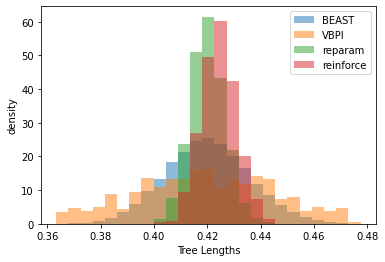

In [99]:
plot_hist(tree_lengths,"Tree Lengths")

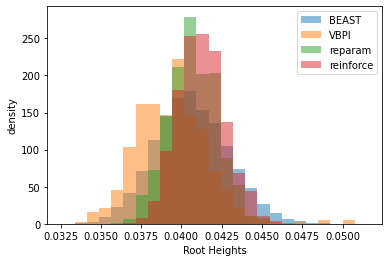

In [100]:
plot_hist(root_heights,"Root Heights")

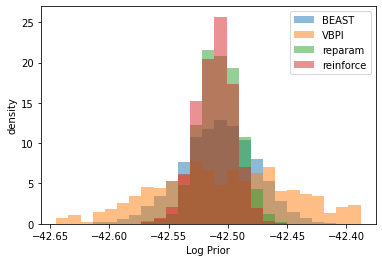

In [101]:
plot_hist(log_priors,"Log Prior")

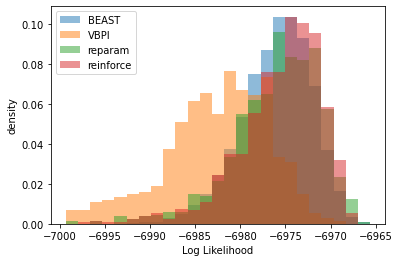

In [102]:
plot_hist(log_likes,"Log Likelihood")

In [103]:
MLLs

{'BEAST': -7154.785311988587,
 'VBPI': -7154.46923828125,
 'reparam': -7155.649605095938,
 'reinforce': -7154.796194423879}

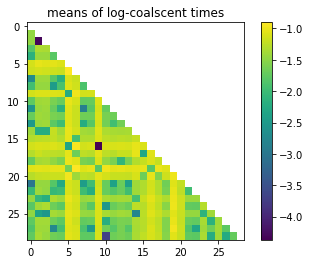

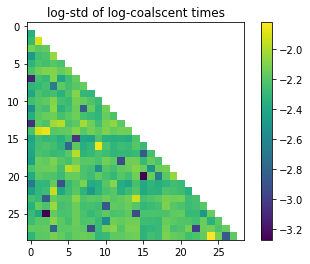

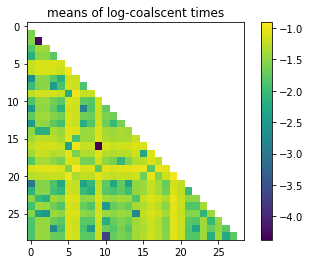

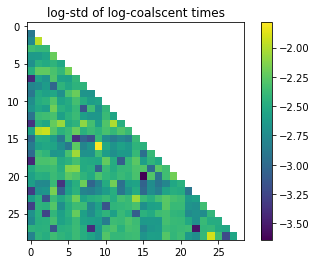

In [58]:
for theta in [optim_reparam.theta,optim_reinforce.theta]:
    m = deepcopy(theta[0])
    m[np.triu_indices(m.shape[0])] = np.nan
    plt.imshow(m)
    plt.title("means of log-coalscent times")
    plt.colorbar()
    plt.show()

    log_sig = deepcopy(theta[1])
    log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
    plt.imshow(log_sig)
    plt.title("log-std of log-coalscent times")
    plt.colorbar()
    plt.show()